In [104]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, SAGEConv


df = pd.read_csv('../Datasets/processed_data.csv')
df_advertiser = pd.read_csv('../Datasets/advertiser_embeddings.csv')
df_keywords = pd.read_csv('../Datasets/keyword_embeddings.csv')
df_search_tags = pd.read_csv('../Datasets/search_tag_embeddings.csv')



In [105]:
df = pd.concat([df, df_advertiser, df_keywords, df_search_tags], axis=1)


In [106]:
# The corresponding click values for each record
engagement_value = torch.tensor(df['engagement_score'].values, dtype=torch.float).view(-1)

# Ensure shapes are appropriate
print(f"engagement shape: {engagement_value.shape}")

engagement shape: torch.Size([58930])


In [107]:
# Initialize HeteroData object
data = HeteroData()

campaign_data = df[['campaign_index','no_of_days', 'campaign_budget_usd']]
# Convert to tensor format
campaign_features = torch.tensor(campaign_data.values, dtype=torch.float)
# data['campaign'] is the campaign node feature storage
data['campaign'].x = campaign_features


platform_data = df[['DV360', 'Facebook Ads', 'Google Ads']]
# Convert to tensor format
platform_features = torch.tensor(platform_data.values, dtype=torch.float)
# data['platform'] is the platform node feature storage
data['platform'].x = platform_features


channel_data = df[['Display', 'Mobile', 
                   'Search', 'Social', 'Video']]
# Convert to tensor format
channel_features = torch.tensor(channel_data.values, dtype=torch.float)
# data['channel'] is the channel node feature storage
data['channel'].x = channel_features


creative_data = df[['has_image']]
# Convert to tensor format
creative_features = torch.tensor(creative_data.values, dtype=torch.float)
# data['creative'] is the creative node feature storage
data['creative'].x = creative_features


keyword_data = df[[f'keyword_emb_{i}' for i in range(50)]]  # fetching the embeddings columns
# Convert to tensor format
keyword_features = torch.tensor(keyword_data.values, dtype=torch.float)
# Store in the data dictionary for keyword nodes
data['keywords'].x = keyword_features


advertiser_data = df[[f'advertiser_emb_{i}' for i in range(50)]]  # fetching the embeddings columns
# Concatenate advertiser_id with the embeddings -> Resulting shape (69,000, 51)
advertiser_features = torch.tensor(advertiser_data.values, dtype=torch.float)
# Assign to the advertiser node in your graph
data['advertiser'].x = advertiser_features


search_tags_data = df[[f'search_tag_emb_{i}' for i in range(50)]]  # fetching the embeddings columns
# Convert to tensor format
search_tag_features = torch.tensor(search_tags_data.values, dtype=torch.float)
# Store in the data dictionary for keyword nodes
data['search_tag'].x = search_tag_features

template_data = df[['template_id']]
# Convert to tensor format
template_features = torch.tensor(template_data.values, dtype=torch.float)
# data['template'] is the template node feature storage
data['template'].x = template_features

network_data = df[['network_id']]
# Convert to tensor format
network_features = torch.tensor(network_data.values, dtype=torch.float)
# data['network'] is the network node feature storage
data['network'].x = network_features

region_data = df[['Africa/Cairo','America/New_York','Asia/Calcutta',
                'Asia/Kolkata', 'Asia/Muscat' ,'Asia/Singapore', 'US/Eastern']]
# Convert to tensor format
region_features = torch.tensor(region_data.values, dtype=torch.float)
# data['region'] is the region node feature storage
data['region'].x = region_features

currency_data = df[['AED','EGP','INR','SGD','USD']]
# Convert to tensor format
currency_features = torch.tensor(currency_data.values, dtype=torch.float)
# data['currency'] is the currency node feature storage
data['currency'].x = currency_features

In [108]:

# Edges (Campaign → Platform)
data['campaign', 'hosted_on', 'platform'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # platform indices
], dtype=torch.long)


data['platform', 'rev_hosted_on', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # platform indices
    [0, 1]   # campaign indices
], dtype=torch.long)


# Edges (Campaign → Channel)
data['campaign', 'uses', 'channel'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)

data['channel', 'rev_uses', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # channel indices
    [0, 1]   # campaign indices
], dtype=torch.long)


# Edges (Platform → channel)
data['platform', 'supports', 'channel'].edge_index = torch.tensor([
    [0, 1],  # platform indices
    [0, 1]   # channel indices
], dtype=torch.long)


# Edges (Campaign → Creative)
data['campaign', 'uses', 'creative'].edge_index = torch.tensor([
    [0, 1],  # creative indices
    [0, 1]   # campaign indices
], dtype=torch.long)

data['creative', 'rev_uses', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # creative indices
    [0, 1]   # campaign indices
], dtype=torch.long)

# Edges (Creative → Template)
data['creative', 'designed_with', 'template'].edge_index = torch.tensor([
    [0, 1],  # creative indices
    [0, 1]   # template indices
], dtype=torch.long)


data['campaign', 'associated_with', 'keywords'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)


data['keywords', 'rev_associated_with', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # channel indices
    [0, 1]   # campaign indices
], dtype=torch.long)    


data['platform', 'optimized_for', 'keywords'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)


data['campaign', 'managed_by', 'network'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)


data['campaign','belongs_to','advertiser'].edge_index = torch.tensor([
    [0, 1],
    [0, 1]
], dtype=torch.long)

# Edges (Campaign → Search Tag)
data['campaign', 'targeted_with', 'search_tag'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # search tag indices
], dtype=torch.long)

data['search_tag', 'rev_targeted_with', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # search tag indices
    [0, 1]   # campaign indices
], dtype=torch.long)

data['campaign', 'targeted_in', 'region'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # region indices
], dtype=torch.long)

data['campaign', 'uses', 'currency'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # currency indices
], dtype=torch.long)


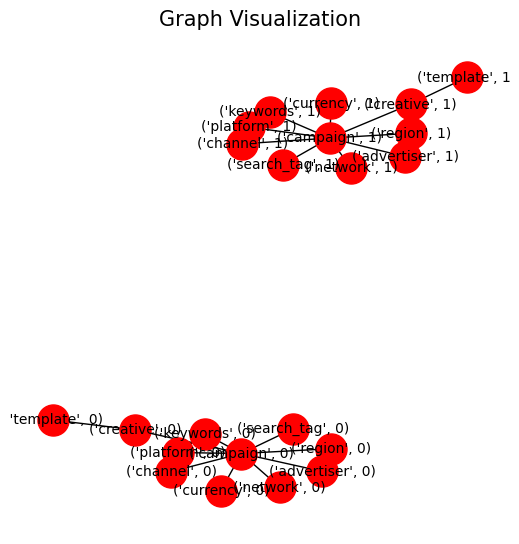

In [109]:
import matplotlib.pyplot as plt
import networkx as nx
import torch

def visualize_graph(data):
    # Create a new graph using NetworkX
    G = nx.Graph()

    # Add nodes and edges to the graph
    for edge_type, edge_index in data.edge_index_dict.items():
        src_type, _, dst_type = edge_type  # Extract source and destination node types
        for src, dst in edge_index.t().tolist():  # Add edges to the graph
            # Add nodes as (node_type, node_id)
            G.add_node((src_type, src))
            G.add_node((dst_type, dst))
            G.add_edge((src_type, src), (dst_type, dst))
    
    # Position nodes using the spring layout (force-directed layout)
    pos = nx.spring_layout(G)

    # Draw the graph
    plt.figure(figsize=(5, 5))
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='red', font_size=10)
    plt.title("Graph Visualization", fontsize=15)
    plt.show()

# Visualize the graph
visualize_graph(data)


In [110]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv
from torch.optim.lr_scheduler import StepLR


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class HeteroGCN(torch.nn.Module):
    def __init__(self, hidden_dim, num_layers=3):  # Dynamic num_layers
        super().__init__()

        # Define the relations once to avoid repetition
        self.relations = [
            ('campaign', 'hosted_on', 'platform'),
            ('platform', 'rev_hosted_on', 'campaign'),
            ('campaign', 'uses', 'channel'),
            ('channel', 'rev_uses', 'campaign'),
            ('platform', 'supports', 'channel'),
            ('campaign', 'uses', 'creative'),
            ('creative', 'rev_uses', 'campaign'),
            ('creative', 'designed_with', 'template'),
            ('campaign', 'associated_with', 'keywords'),
            ('keywords', 'rev_associated_with', 'campaign'),
            ('campaign', 'managed_by', 'network'),
            ('platform', 'optimized_for', 'keywords'),
            ('campaign', 'belongs_to', 'advertiser'),
            ('campaign', 'targeted_with', 'search_tag'),
            ('search_tag', 'rev_targeted_with', 'campaign'),
            ('campaign', 'targeted_in', 'region'),
            ('campaign', 'uses', 'currency')
        ]

        # Create HeteroConv layers dynamically
        self.convs = torch.nn.ModuleList([
            HeteroConv({rel: SAGEConv((-1, -1), hidden_dim) for rel in self.relations}, aggr="mean")
            for _ in range(num_layers)
        ])

        # LayerNorms for stability
        self.norms = torch.nn.ModuleList([torch.nn.LayerNorm(hidden_dim) for _ in range(num_layers)])

        # Fully connected layer for classification
        self.fc = torch.nn.Linear(hidden_dim * 11, 1)

    def forward(self, x_dict, edge_index_dict):
        for conv, norm in zip(self.convs, self.norms):
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: norm(F.leaky_relu(x, negative_slope=0.01)) for key, x in x_dict.items()}

        # Concatenate the features for classification
        x_combined = torch.cat([
            x_dict['campaign'], x_dict['platform'], x_dict['channel'], x_dict['creative'],
            x_dict['keywords'], x_dict['search_tag'], x_dict['advertiser'], x_dict['network'],
            x_dict['template'], x_dict['region'], x_dict['currency']
        ], dim=1)

        # Pass through the fully connected layer
        out = self.fc(x_combined)

        return torch.sigmoid(out).squeeze(-1)  # Sigmoid for binary classification


In [111]:
# Training Loop (classification)
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split

# Assuming target labels are available and are integers representing classes
target_labels = engagement_value.float()  # Ensure labels are integers for classification

# Get indices for campaigns (assuming 'campaign' nodes are being predicted)
campaign_indices = torch.arange(data.x_dict['campaign'].size(0))

# 80% Train, 20% Test Split
train_idx, test_idx = train_test_split(campaign_indices.cpu().numpy(), test_size=0.2, random_state=42)

# Convert to tensors
train_idx = torch.tensor(train_idx, dtype=torch.long, device=device)
test_idx = torch.tensor(test_idx, dtype=torch.long, device=device)

In [112]:
from sklearn.preprocessing import StandardScaler

# # Normalize node features
scaler = StandardScaler()
for key in data.x_dict.keys():
    data.x_dict[key] = torch.tensor(scaler.fit_transform(data.x_dict[key].cpu().numpy()), dtype=torch.float32, device=device)

# Initialize model
model = HeteroGCN(hidden_dim=32).to(device)

# Define optimizer & scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=25, gamma=0.5)  # Adjust step size

num_epochs = 100
best_mse = float('inf')

train_losses, test_losses = [], []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    out = model(data.x_dict, data.edge_index_dict)

    # 🔹 Use Huber Loss instead of MSE
    train_loss = F.smooth_l1_loss(out[train_idx], engagement_value[train_idx])
    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())

    # 🔹 Evaluate on test data
    model.eval()
    with torch.no_grad():
        test_out = model(data.x_dict, data.edge_index_dict)
        test_loss = F.smooth_l1_loss(test_out[test_idx], engagement_value[test_idx])

    test_losses.append(test_loss.item())

    print(f"Epoch {epoch}, Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

    # 🔹 Update LR scheduler
    scheduler.step()


Epoch 0, Train Loss: 0.0261, Test Loss: 0.0256
Epoch 1, Train Loss: 0.0251, Test Loss: 0.0270
Epoch 2, Train Loss: 0.0265, Test Loss: 0.0198
Epoch 3, Train Loss: 0.0194, Test Loss: 0.0151
Epoch 4, Train Loss: 0.0148, Test Loss: 0.0179
Epoch 5, Train Loss: 0.0178, Test Loss: 0.0195
Epoch 6, Train Loss: 0.0195, Test Loss: 0.0169
Epoch 7, Train Loss: 0.0168, Test Loss: 0.0146
Epoch 8, Train Loss: 0.0144, Test Loss: 0.0151
Epoch 9, Train Loss: 0.0148, Test Loss: 0.0166
Epoch 10, Train Loss: 0.0162, Test Loss: 0.0170
Epoch 11, Train Loss: 0.0166, Test Loss: 0.0161
Epoch 12, Train Loss: 0.0158, Test Loss: 0.0148
Epoch 13, Train Loss: 0.0146, Test Loss: 0.0143
Epoch 14, Train Loss: 0.0142, Test Loss: 0.0148
Epoch 15, Train Loss: 0.0147, Test Loss: 0.0154
Epoch 16, Train Loss: 0.0153, Test Loss: 0.0153
Epoch 17, Train Loss: 0.0152, Test Loss: 0.0147
Epoch 18, Train Loss: 0.0146, Test Loss: 0.0143
Epoch 19, Train Loss: 0.0141, Test Loss: 0.0144
Epoch 20, Train Loss: 0.0142, Test Loss: 0.0147
Ep

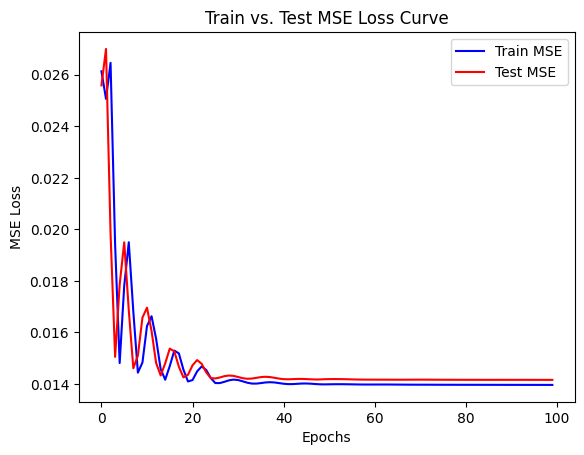

In [113]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_losses)), train_losses, label="Train MSE", color='blue')
plt.plot(range(len(test_losses)), test_losses, label="Test MSE", color='red')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Train vs. Test MSE Loss Curve")
plt.show()


In [114]:
import torch.nn.functional as F

def evaluate_model(model, data, engagement_value, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():  # Disable gradient calculation during evaluation
        # Move data to the correct device
        data = data.to(device)
        engagement_value = engagement_value.to(device)
        # Forward pass
        out = model(data.x_dict, data.edge_index_dict)
        # Ensure shapes match
        out = out[test_idx]
        engagement_value = engagement_value[test_idx]
        # Compute MSE loss between predictions and actual click values
        mse = F.mse_loss(out, engagement_value)  
        return mse.item()
    
# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluate the model
mse_score = evaluate_model(model, data, engagement_value, device)
print(f"Test MSE: {mse_score:.4f}")


Test MSE: 0.0283


In [115]:
import torch
import torch.nn.functional as F

def r_squared(y_true, y_pred):
    """Calculate the R² (coefficient of determination) score."""
    # Move tensors to CPU and convert to numpy arrays
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    
    # Compute the total sum of squares and residual sum of squares
    ss_tot = ((y_true - y_true.mean()) ** 2).sum()
    ss_res = ((y_true - y_pred) ** 2).sum()
    
    print(f"SS_Total: {ss_tot}, SS_Res: {ss_res}")


    # Return R² score with safeguard against division by zero
    return 1 - (ss_res / (ss_tot + 1e-8))

# Ensure the model is in evaluation mode
model.eval()

# Move model and data to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
data = data.to(device)
engagengagement_value =engagement_value.to(device)

with torch.no_grad():
    # Forward pass on the full dataset
    predictions = model(data.x_dict, data.edge_index_dict)
    predictions = predictions.squeeze()
    y_true =engagement_value.view(-1)
    
    # Apply test indices to avoid data leakage
    predictions = predictions[test_idx]
    y_true = y_true[test_idx]

    # Optional: Check for shape consistency
    assert predictions.shape == y_true.shape, f"Shape mismatch: {predictions.shape} vs {y_true.shape}"


# Compute R² score
r2_score = r_squared(y_true, predictions)
print(f"Test R²: {r2_score:.4f}")


SS_Total: 336.3308410644531, SS_Res: 333.75537109375
Test R²: 0.0077


In [116]:
print(f"Sample y_true: {y_true[:10]}")
print(f"Sample Predictions: {predictions[:10]}")


Sample y_true: tensor([0.1448, 0.4138, 0.1021, 0.4652, 0.6312, 0.3927, 0.6202, 0.2999, 0.6198,
        0.0932])
Sample Predictions: tensor([0.3735, 0.3935, 0.3792, 0.3789, 0.4119, 0.3908, 0.3786, 0.3845, 0.3942,
        0.4003])


In [117]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv

# Assuming your model is defined as 'model'

# New data for prediction (single data point)
new_campaign = torch.tensor([[1000, 3, 8]], dtype=torch.float)  # Single new campaign feature (1 new campaign)

new_platform = torch.tensor([[0, 1, 0]], dtype=torch.float)  # Single new platform feature (1 new platform)

new_channel = torch.tensor([[0, 0, 0, 0, 1]], dtype=torch.float)  # Single new channel feature (1 new channel)

new_creative = torch.tensor([[1]], dtype=torch.float)  # Single new creative feature (1 new creative)

new_template = torch.tensor([[91]], dtype=torch.float)  # Single new template feature (1 new template)

new_network = torch.tensor([[190]], dtype=torch.float)  # Single new network feature (1 new network)

new_keywords = torch.rand((1, 50), dtype=torch.float)  # Single new keywords feature (1 new keywords)

new_advertiser = torch.rand((1, 50), dtype=torch.float)  # Single new advertiser feature (1 new advertiser)

new_search_tag = torch.rand((1, 50), dtype=torch.float)  # Single new advertiser feature (1 new advertiser)

new_region = torch.tensor([[0, 0, 0, 0, 0, 0, 1]], dtype=torch.float)  # Single new region feature (1 new region)

new_currency = torch.tensor([[0, 0, 0, 0, 1]], dtype=torch.float)  # Single new currency feature (1 new currency)


# Add the new nodes and their features to the graph
data['campaign'].x = torch.cat([data['campaign'].x, new_campaign], dim=0)
data['platform'].x = torch.cat([data['platform'].x, new_platform], dim=0)
data['channel'].x = torch.cat([data['channel'].x, new_channel], dim=0)
data['creative'].x = torch.cat([data['creative'].x, new_creative], dim=0)
data['template'].x = torch.cat([data['template'].x, new_template], dim=0)
data['network'].x = torch.cat([data['network'].x, new_network], dim=0)
data['keywords'].x = torch.cat([data['keywords'].x, new_keywords], dim=0)
data['advertiser'].x = torch.cat([data['advertiser'].x, new_advertiser], dim=0)
data['search_tag'].x = torch.cat([data['search_tag'].x, new_search_tag], dim=0)
data['region'].x = torch.cat([data['region'].x, new_region], dim=0)
data['currency'].x = torch.cat([data['currency'].x, new_currency], dim=0)

new_campaign_index = data['campaign'].x.size(0) - 1
new_platform_index = data['platform'].x.size(0) - 1
new_channel_index = data['channel'].x.size(0) - 1
new_creative_index = data['creative'].x.size(0) - 1
new_template_index = data['template'].x.size(0) - 1
new_network_index = data['network'].x.size(0) - 1
new_keywords_index = data['keywords'].x.size(0) - 1
new_advertiser_index = data['advertiser'].x.size(0) - 1
new_search_tag_index = data['search_tag'].x.size(0) - 1
new_region_index = data['region'].x.size(0) - 1
new_currency_index = data['currency'].x.size(0) - 1



data['campaign', 'hosted_on', 'platform'].edge_index = torch.cat(
    [data['campaign', 'hosted_on', 'platform'].edge_index,
     torch.tensor([[new_campaign_index], [new_platform_index]], dtype=torch.long)], dim=1
)

data['platform', 'rev_hosted_on', 'campaign'].edge_index = torch.cat(
    [data['platform', 'rev_hosted_on', 'campaign'].edge_index,
     torch.tensor([[new_platform_index], [new_campaign_index]], dtype=torch.long)], dim=1
)

data['campaign', 'uses', 'channel'].edge_index = torch.cat(
    [data['campaign', 'uses', 'channel'].edge_index,
     torch.tensor([[new_campaign_index], [new_channel_index]], dtype=torch.long)], dim=1
)

data['channel', 'rev_uses', 'campaign'].edge_index = torch.cat(
    [data['channel', 'rev_uses', 'campaign'].edge_index,
     torch.tensor([[new_channel_index], [new_campaign_index]], dtype=torch.long)], dim=1
)

data['platform', 'supports', 'channel'].edge_index = torch.cat(
    [data['platform', 'supports', 'channel'].edge_index,
     torch.tensor([[new_platform_index], [new_channel_index]], dtype=torch.long)], dim=1
)


data['campaign', 'uses', 'creative'].edge_index = torch.cat(
    [data['campaign', 'uses', 'creative'].edge_index,
     torch.tensor([[new_campaign_index], [new_creative_index]], dtype=torch.long)], dim=1
)

data['creative', 'designed_with', 'template'].edge_index = torch.cat(
    [data['creative', 'designed_with', 'template'].edge_index,
     torch.tensor([[new_creative_index], [new_template_index]], dtype=torch.long)], dim=1
)

data['campaign', 'associated_with', 'keywords'].edge_index = torch.cat(
    [data['campaign', 'associated_with', 'keywords'].edge_index,
     torch.tensor([[new_campaign_index], [new_keywords_index]], dtype=torch.long)], dim=1
)

data['campaign', 'managed_by', 'network'].edge_index = torch.cat(
    [data['campaign', 'managed_by', 'network'].edge_index,
     torch.tensor([[new_campaign_index], [new_network_index]], dtype=torch.long)], dim=1
)

data['platform', 'optimized_for', 'keywords'].edge_index = torch.cat(
    [data['platform', 'optimized_for', 'keywords'].edge_index,
     torch.tensor([[new_platform_index], [new_keywords_index]], dtype=torch.long)], dim=1
)

data['campaign', 'belongs_to', 'advertiser'].edge_index = torch.cat(
    [data['campaign', 'belongs_to', 'advertiser'].edge_index,
     torch.tensor([[new_campaign_index], [new_advertiser_index]], dtype=torch.long)], dim=1
)

data['campaign', 'targeted_with', 'search_tag'].edge_index = torch.cat(
    [data['campaign', 'targeted_with', 'search_tag'].edge_index,
     torch.tensor([[new_campaign_index], [new_search_tag_index]], dtype=torch.long)], dim=1
)


data['search_tag', 'rev_targeted_with', 'campaign'].edge_index = torch.cat(
    [data['search_tag', 'rev_targeted_with', 'campaign'].edge_index,
     torch.tensor([[new_campaign_index], [new_search_tag_index]], dtype=torch.long)], dim=1
)

data['campaign', 'targeted_in', 'region'].edge_index = torch.cat(
    [data['campaign', 'targeted_in', 'region'].edge_index,
     torch.tensor([[new_campaign_index], [new_region_index]], dtype=torch.long)], dim=1
)

data['campaign', 'uses', 'currency'].edge_index = torch.cat(
    [data['campaign', 'uses', 'currency'].edge_index,
     torch.tensor([[new_campaign_index], [new_currency_index]], dtype=torch.long)], dim=1
)

In [118]:
# Run model inference
model.eval()
with torch.no_grad():
    output = model(data.x_dict, data.edge_index_dict)

new_campaign_pred = output[-1]  # Assuming last row corresponds to the new campaign
print("Predicted clicks for new campaign:", new_campaign_pred.item())

Predicted clicks for new campaign: 0.4506707489490509


In [119]:
print("First 10 predictions:\n", output[:10])
print("Output shape:", output.shape)
print("Number of campaign nodes:", len(data.x_dict['campaign']))


First 10 predictions:
 tensor([0.2950, 0.4292, 0.4098, 0.4132, 0.4075, 0.4211, 0.4117, 0.4092, 0.4141,
        0.4145])
Output shape: torch.Size([58931])
Number of campaign nodes: 58931


In [120]:
torch.save(model.state_dict(), "sage_model.pth")  # ✅ Save only weights
